<a href="https://colab.research.google.com/github/HTAL02/hello-word/blob/main/RNN_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importation des librairies

In [ ]:
import numpy as np
import math
#import matplotlib.pyplot as plt
import random
import time

Génération du jeu de données

In [ ]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)]) #vecteur de sinsus de 0 à 199

#visualise sine_wave
#plt.plot(sin_wave[:50])
#plt.show()

In [ ]:
#creating data
def create_data(sin_wave):
    X = []
    Y = []

    seq_len = 50
    num_records = len(sin_wave) - seq_len

    for i in range(num_records - 50):
        X.append(sin_wave[i:i+seq_len])
        Y.append(sin_wave[i+seq_len])
        
    X = np.array(X)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=1)
    return X, Y

X, Y = create_data(sin_wave)

Y[1].shape

(1,)

Initialisation des matrices de poids

In [ ]:
def init_weigth(hidden_dim,output_dim , seq_lenth):
    U = np.random.uniform(0, 1, (hidden_dim, seq_lenth))
    W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
    V = np.random.uniform(0, 1, (output_dim, hidden_dim))
    weigth = dict(U = U, W = W, V = V)
    return weigth

Definition des fonctions d'activation

In [ ]:
def fw_sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bw_sigmoid(x, output):
    return output * (1. - output) * x
    

Propagation avant

In [ ]:
def foward_prop(input_data, output_data, seq_lenth, weigth, prev_s, layers):
    #input_data et output_data sont les entrées et sortie d'un example du dataset
    #weigth est un dictionaire de l'ensemble des matrices de poids
    #prev est l'etat precedant de la sortie active
  
    U, V, W = weigth['U'], weigth['V'], weigth['W']
    
    for t in range(seq_lenth):
        new_input = np.zeros(input_data.shape)
        new_input[t] = input_data[t]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = fw_sigmoid(add)
        y_pred = np.dot(V, s)
        layers.append({'s':s, 'prev_s':prev_s})
        prev_s = s
        
    cache = (mulu, mulw, add)
    loss_per_record = (output_data - y_pred)**2 / 2
    return y_pred, layers, cache, loss_per_record 
    

Back propagation

In [ ]:

def cliping(derivate, min_clip_val, max_clip_val):
    dU, dW, dV = derivate
    
    if dU.max() > max_clip_val:
        dU[dU > max_clip_val] = max_clip_val
    if dV.max() > max_clip_val:
        dV[dV > max_clip_val] = max_clip_val
    if dW.max() > max_clip_val:
        dW[dW > max_clip_val] = max_clip_val
                
            
    if dU.min() < min_clip_val:
        dU[dU < min_clip_val] = min_clip_val
    if dV.min() < min_clip_val:
        dV[dV < min_clip_val] = min_clip_val
    if dW.min() < min_clip_val:
        dW[dW < min_clip_val] = min_clip_val
        
    derivate_cliped = (dU, dW, dV)
    
    return derivate_cliped   

In [ ]:
def back_prop(input_data, seq_lenth, derivate_pred, weigth, cache, layers, bptt_trunc,min_clip_val, max_clip_val):
    
    U, V, W = weigth['U'], weigth['V'], weigth['W']
    mulu, mulw, add = cache
    
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
        
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
        
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    for t in range(seq_lenth):
        dV_t = np.dot(derivate_pred, np.transpose(layers[t]['s']))
        dsv = np.dot(np.transpose(V), derivate_pred)
            
        ds = dsv
        dadd = bw_sigmoid(ds, add)
            
        dmulw = dadd * np.ones_like(mulw)

        dprev_s = np.dot(np.transpose(W), dmulw)


        for i in range(t-1, max(-1, t - bptt_trunc - 1), -1):
            ds = dsv + dprev_s
            dadd = bw_sigmoid(ds, add)

            dmulw = dadd * np.ones_like(mulw)
            dmulu = dadd * np.ones_like(mulu)

            dW_i = np.dot(W, layers[t]['prev_s'])
            dprev_s = np.dot(np.transpose(W), dmulw)

            new_input = np.zeros(input_data.shape)
            new_input[t] = input_data[t]
            dU_i = np.dot(U, new_input)
            dx = np.dot(np.transpose(U), dmulu)

            dU_t += dU_i
            dW_t += dW_i
                
        dV += dV_t
        dU += dU_t
        dW += dW_t
        
        derivate = (dU, dW, dV)
        derivate = cliping(derivate, min_clip_val, max_clip_val)
        
    return derivate

Entrainement 

In [ ]:
def train_rnn(X, Y,alpha, nepoch, seq_lenth, hidden_dim, output_dim, bptt_trunc, min_clip_val, max_clip_val):
    #U, V, W = weigth['U'], weigth['V'], weigth['W']
    weigth = init_weigth(hidden_dim, output_dim , seq_lenth)
    print(weigth['U'][1,1])

    for epoch in range(nepoch):
        loss = []
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            #T = x.shape[0]
    
            layers = []
            prev_s = np.zeros((hidden_dim, 1))
        
        #propagation avant
            y_pred, layers, cache, loss_per_record = foward_prop(x, y, seq_lenth, weigth, prev_s, layers)
            loss.append(loss_per_record)

            derivate_pred = (y_pred - y)
        
        #propagation arrière
            derivate_weigth = back_prop(x, seq_lenth, derivate_pred, weigth, cache, layers, bptt_trunc, min_clip_val, max_clip_val)
            dU, dW, dV = derivate_weigth
            
            weigth['U'] -= (alpha * dU)
            weigth['V'] -= (alpha * dV)
            weigth['W'] -= (alpha * dW)
            #print('weigth['U'][1,1] = ' ,weigth['U'][1,1])

        total_loss = sum(loss) / float(y.shape[0])
        print('Epoch: ', epoch + 1, ', Loss: ', total_loss)
        #print('dU[1,1] = ' ,dU[1,1])
        #print('weigth[\'U\'][1,1] = ' ,weigth['U'][1,1])
        #print('')
    return weigth

Prédictions

In [ ]:
def prediction(X, seq_lenth, weigth ,hidden_dim):
    U, V, W = weigth['U'], weigth['V'], weigth['W']
    preds = []
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_s = np.zeros((hidden_dim, 1))
        # Forward pass
        for t in range(seq_lenth):
            mulu = np.dot(U, x)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = fw_sigmoid(add)
            y_pred = np.dot(V, s)
            prev_s = s

        preds.append(y_pred)
    
    preds = np.array(preds)
    
    return preds

EXPERIMENTATION

Initialisation des paramètres du model

In [ ]:
#RNN architecture

learning_rate = 0.0001    
nepoch = 25               
T = 50               # length of sequence
hidden_dimesion = 100         
output_dimesion = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [ ]:
#weigth = init_weigth(hidden_dim, output_dim , T)
#print(weigth['U'][1,1])

Entrainement du model

In [ ]:
start = time.time()
new_weigth = train_rnn(X, Y, learning_rate, nepoch, T, hidden_dimesion, output_dimesion, bptt_truncate, min_clip_value, max_clip_value)
end = time.time()

0.17670947624099853
Epoch:  1 , Loss:  [[88998.21038554]]
Epoch:  2 , Loss:  [[51912.14241113]]
Epoch:  3 , Loss:  [[24826.07397808]]
Epoch:  4 , Loss:  [[7736.68962554]]
Epoch:  5 , Loss:  [[580.21010423]]
Epoch:  6 , Loss:  [[22.38632457]]
Epoch:  7 , Loss:  [[18.31770822]]
Epoch:  8 , Loss:  [[18.52987225]]
Epoch:  9 , Loss:  [[18.7867647]]
Epoch:  10 , Loss:  [[18.2127295]]
Epoch:  11 , Loss:  [[18.12354122]]
Epoch:  12 , Loss:  [[17.82281101]]
Epoch:  13 , Loss:  [[18.52842403]]
Epoch:  14 , Loss:  [[18.49167382]]
Epoch:  15 , Loss:  [[18.41215045]]
Epoch:  16 , Loss:  [[18.57600021]]
Epoch:  17 , Loss:  [[18.80237338]]
Epoch:  18 , Loss:  [[18.82570974]]
Epoch:  19 , Loss:  [[19.17056325]]
Epoch:  20 , Loss:  [[19.12688848]]
Epoch:  21 , Loss:  [[19.14586094]]
Epoch:  22 , Loss:  [[19.12631592]]
Epoch:  23 , Loss:  [[19.17072576]]
Epoch:  24 , Loss:  [[19.05801888]]
Epoch:  25 , Loss:  [[19.09194728]]


In [ ]:
#prediction
Y_true = prediction(X, T, new_weigth, hidden_dimesion)

#print('new_weigth[\'U\'][1,1]', new_weigth['U'][1,1])
#print('length of preds = ' ,Y_true.shape)
#print('Y_true[1] =' , Y_true[1 ,0], 'Y[1] =', Y[1])

time_done = end - start
print("L'entrainement à durée", time_done, "s" )

L'entrainement à durée 71.63318014144897 s


In [ ]:
for i in range(Y.shape[0]):
    print(i + 1,': Y predit =' , Y_true[i ,0], '   |Y reel =', Y[i])

1 : Y predit = [-0.48885684]  |Y reel = [-0.26237485]
2 : Y predit = [0.54214614]  |Y reel = [0.67022918]
3 : Y predit = [1.25482916]  |Y reel = [0.98662759]
4 : Y predit = [0.6652546]  |Y reel = [0.39592515]
5 : Y predit = [-0.45282572]  |Y reel = [-0.55878905]
6 : Y predit = [-1.29812571]  |Y reel = [-0.99975517]
7 : Y predit = [-0.87165241]  |Y reel = [-0.521551]
8 : Y predit = [0.27667192]  |Y reel = [0.43616476]
9 : Y predit = [1.19594709]  |Y reel = [0.99287265]
10 : Y predit = [1.00675725]  |Y reel = [0.63673801]
11 : Y predit = [-0.18664052]  |Y reel = [-0.30481062]
12 : Y predit = [-1.18744541]  |Y reel = [-0.96611777]
13 : Y predit = [-1.14065115]  |Y reel = [-0.7391807]
14 : Y predit = [0.01377518]  |Y reel = [0.1673557]
15 : Y predit = [1.00020991]  |Y reel = [0.92002604]
16 : Y predit = [1.18193824]  |Y reel = [0.82682868]
17 : Y predit = [0.09987388]  |Y reel = [-0.02655115]
18 : Y predit = [-0.92349397]  |Y reel = [-0.85551998]
19 : Y predit = [-1.26628987]  |Y reel = [-

Visualisation des résultat

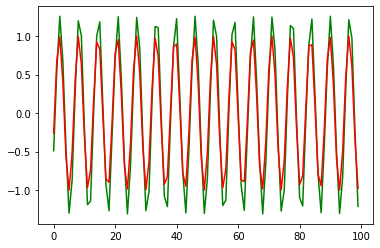

In [ ]:
#plt.plot(Y_true[:, 0, 0], 'g')
#plt.plot(Y[:, 0], 'r')
#plt.show()